In [1]:
from typing_extensions import TypedDict, Annotated
from typing import Dict, List
import os

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_ollama import ChatOllama, OllamaEmbeddings
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_chroma import Chroma
from pydantic import BaseModel, Field

from scripts import my_tools

from dotenv import load_dotenv
load_dotenv()

[DB] Total documents in database: 1270


True

In [ ]:
# =============================================================================
# Configuration
# =============================================================================

CHROMA_DIR = "chroma_financial_db"
COLLECTION_NAME = "financial_docs"
EMBEDDING_MODEL = "nomic-embed-text"
LLM_MODEL = "qwen3"
# LLM_MODEL = "qwen3:14b"
BASE_URL = "http://localhost:11434"
MAX_ITERATIONS = 3


In [3]:
# =============================================================================
# Initialize LLM
# =============================================================================

llm = ChatOllama(model=LLM_MODEL, base_url=BASE_URL)

In [4]:
# =============================================================================
# Pydantic Schemas for Structured Output
# =============================================================================

class Reflection(BaseModel):
    """Critique of current answer."""
    missing: str = Field(description="What critical information is missing or incomplete")
    superfluous: str = Field(description="What information is unnecessary or redundant")

class InitialAnswer(BaseModel):
    """Initial answer with reflection and search queries."""
    answer: str = Field(description="Detailed answer to the question (~250 words)")
    reflection: Reflection = Field(description="Critical reflection on the answer")
    search_queries: List[str] = Field(
        description="1-3 search queries to retrieve missing information"
    )

class RevisedAnswer(BaseModel):
    """Revised answer with citations."""
    answer: str = Field(description="Improved answer incorporating new information (~250 words)")
    reflection: Reflection = Field(description="Critical reflection on the revised answer")
    search_queries: List[str] = Field(
        default_factory=list,
        description="1-3 new search queries if needed, empty list if complete"
    )
    references: List[str] = Field(
        default_factory=list,
        description="Citations in format: 'Company: X, Year: Y, Quarter: Z, Page: N'"
    )
    is_complete: bool = Field(
        default=False,
        description="True if answer is complete and no more searches needed"
    )


In [5]:
# =============================================================================
# State
# =============================================================================

class ReflexionRAGState(TypedDict):
    """State for reflexion RAG system."""
    messages: Annotated[List, add_messages]
    iteration_count: int
    retrieved_docs: str
    search_queries: List[str]
    is_complete: bool

In [6]:
# =============================================================================
# LangGraph Nodes
# =============================================================================

def draft_node(state: ReflexionRAGState) -> Dict:
    """Generate initial answer with reflection."""
    print("\n[NODE] Draft - Generating initial answer")
    
    # Create structured output LLM (Ollama doesn't need method parameter)
    llm_structured = llm.with_structured_output(InitialAnswer)
    
    # Build prompt
    system_prompt = """You are an expert financial document researcher.

TASK:
1. Provide detailed answer (~250 words) to user's question
2. Reflect critically: identify missing and superfluous information
3. Generate 1-3 search queries to retrieve the missing information

Use Markdown formatting (headings, bullets, tables, bold).

Output your response as JSON matching this schema:
{
  "answer": "Your detailed answer here...",
  "reflection": {
    "missing": "What information is missing...",
    "superfluous": "What is unnecessary..."
  },
  "search_queries": ["query1", "query2", "query3"]
}"""
    
    messages = [SystemMessage(content=system_prompt)] + state["messages"]
    
    # Get structured response
    try:
        response = llm_structured.invoke(messages)
    except Exception as e:
        print(f"[ERROR] Failed to parse structured output: {e}")
        # Fallback to simple queries
        response = InitialAnswer(
            answer="I need more information to answer this question properly.",
            reflection=Reflection(
                missing="Financial data and specific metrics",
                superfluous="None"
            ),
            search_queries=["financial data", "revenue information"]
        )
    
    print(f"[DRAFT] Generated answer with {len(response.search_queries)} search queries")
    print(f"[REFLECTION] Missing: {response.reflection.missing[:100]}...")
    
    # Create AI message with the response
    ai_message = AIMessage(
        content=f"**Initial Answer:**\n\n{response.answer}\n\n"
                f"**Reflection:**\n- Missing: {response.reflection.missing}\n"
                f"- Superfluous: {response.reflection.superfluous}\n\n"
                f"**Search Queries:** {', '.join(response.search_queries)}"
    )
    
    return {
        "messages": [ai_message],
        "iteration_count": 1,
        "search_queries": response.search_queries
    }


In [7]:
def retrieve_node(state: ReflexionRAGState) -> Dict:
    """Execute search queries and retrieve documents."""
    print("\n[NODE] Retrieve - Fetching documents")
    
    # Get search queries from the last state update
    search_queries = state.get("search_queries", [])
    
    if not search_queries:
        print("[RETRIEVE] No search queries found, skipping retrieval")
        return {"retrieved_docs": ""}
    
    # Process each query using my_tools.retrieve_docs
    print(f"\n[RETRIEVAL] Processing {len(search_queries)} queries")
    
    all_retrieved_text = []
    
    for query_idx, query in enumerate(search_queries, 1):
        print(f"[QUERY {query_idx}] {query}")
        
        # Call my_tools.retrieve_docs for each query
        result = my_tools.retrieve_docs.invoke({'query': query, 'k': 3})
        
        # Format with query header
        all_retrieved_text.append(f"\n--- Query {query_idx}: {query} ---\n{result}")
    
    # Combine all results
    combined_result = "\n\n".join(all_retrieved_text)
    
    # Save for debugging
    os.makedirs("debug_logs", exist_ok=True)
    with open("debug_logs/reflexion_retrieved_docs.md", "w", encoding="utf-8") as f:
        f.write(combined_result)    
    
    return {
        "retrieved_docs": combined_result
    }

In [8]:

def revise_node(state: ReflexionRAGState) -> Dict:
    """Revise answer with new information."""
    print(f"\n[NODE] Revise - Iteration {state.get('iteration_count', 1)}")
    
    # Create structured output LLM
    llm_structured = llm.with_structured_output(RevisedAnswer)
    
    # Get retrieved docs
    retrieved_docs = state.get('retrieved_docs', 'No documents retrieved yet')
    
    system_prompt = """You are an expert financial document researcher.

OUTPUT FORMAT: Valid JSON only. No explanations outside JSON.

TASK:
1. Write DETAILED answer (~250-300 words) with MARKDOWN formatting:
   - Use ## headings, **bold**, bullet points, tables
   - Add inline citations [1], [2]
2. List references: "Company: x, Year: y, Quarter: z, Page: n"
3. Generate search queries for missing information

**CRITICAL RULE - SEARCH QUERIES:**

Ask yourself these questions:
- Do I have complete quarterly breakdown? (q1, q2, q3, q4)
- Do I have segment-wise data? (North America, International, AWS)
- Do I have year-over-year comparisons?
- Do I have operating income, margins, cash flow?
- Do I have balance sheet items if asked?
- Do I have all companies mentioned in the question?

If ANY of these are missing -> Generate 2-3 SPECIFIC search queries

**SEARCH QUERY EXAMPLES (Use specific keywords):**

Good queries (specific, targeted):
✓ "Amazon q1 q2 2023 quarterly revenue"
✓ "Amazon 2023 AWS segment earnings"
✓ "Amazon 2023 operating income margins"
✓ "Amazon 2023 cash flow statement"
✓ "Amazon 2023 balance sheet total assets"
✓ "Apple q1 2024 iphone macbook revenue"

Bad queries (too vague):
✗ "Amazon revenue"
✗ "financial data"
✗ "more information"

**DECISION LOGIC:**

Step 1: Check what information you have from retrieved documents
Step 2: Check what the user's question asks for
Step 3: Identify gaps between what you have and what's needed

If COMPLETE (have ALL information needed to fully answer):
{
  "answer": "## Detailed answer with all data...",
  "is_complete": true,
  "search_queries": [],
  "reflection": {"missing": "None", "superfluous": "None"},
  "references": ["Company: amazon, Year: 2023, Page: 5"]
}

If INCOMPLETE (missing ANY required data):
{
  "answer": "## Answer with available data...",
  "is_complete": false,
  "search_queries": ["specific query 1", "specific query 2"],
  "reflection": {"missing": "List exact missing items", "superfluous": "None"},
  "references": ["Company: amazon, Year: 2023, Page: 5"]
}

**MANDATORY RULES:**
- If is_complete=false -> MUST have 2-3 search_queries
- Queries must be specific with keywords (company, year, quarter, metric)
- Do NOT return empty search_queries unless answer is 100% complete
- Use lowercase for all metadata (company names, quarters, doc types)

**MARKDOWN FORMATTING:**
Your answer field should use rich Markdown:
- ## Main Heading
- ### Subheadings
- **Bold** for key metrics
- Bullet points for lists
- Tables for comparisons
- Inline citations [1], [2]"""
    
    messages = [SystemMessage(content=system_prompt)] +\
                [state["messages"][-1]] + \
                [HumanMessage(content=f"RETRIEVED DOCUMENTS:\n{retrieved_docs}\n\nRevise answer using these documents. If data is missing, provide 2-3 specific search queries. Output JSON only.")]

    # Get structured response
    try:
        response = llm_structured.invoke(messages)
        
        # SAFETY CHECK
        if not response.is_complete and not response.search_queries:
            print("[WARNING] LLM returned no search_queries. Forcing completion.")
            print(f"[DEBUG] is_complete: {response.is_complete}")
            print(f"[DEBUG] missing: {response.reflection.missing}")
            response.is_complete = True
            
    except Exception as e:
        print(f"[ERROR] Failed to parse: {e}")
        response = RevisedAnswer(
            answer="Error parsing response.",
            reflection=Reflection(missing="Valid response", superfluous="None"),
            search_queries=[],
            references=[],
            is_complete=True
        )
    
    print(f"[REVISE] Complete: {response.is_complete}")
    print(f"[REVISE] New queries: {len(response.search_queries)}")
    if response.search_queries:
        for i, q in enumerate(response.search_queries, 1):
            print(f"  =>[{i}] {q}")
    
    # Create AI message
    references_text = "\n".join([f"[{i+1}] {ref}" for i, ref in enumerate(response.references)]) if response.references else "None"

    ai_message = AIMessage(
        content=f"**Revised Answer:**\n\n{response.answer}\n\n"
                f"**References:**\n{references_text}\n\n"
                f"**Reflection:**\n- Missing: {response.reflection.missing}\n"
                f"- Superfluous: {response.reflection.superfluous}\n\n"
                f"**Status:** {'Complete ✓' if response.is_complete else 'Needs more information'}"
    )
    
    return {
        "messages": [ai_message],
        "iteration_count": state.get("iteration_count", 1) + 1,
        "search_queries": response.search_queries,
        "is_complete": response.is_complete
    }

In [9]:
# =============================================================================
# Router Logic
# =============================================================================

def should_continue(state: ReflexionRAGState) -> str:
    """Decide whether to continue reflection loop or end."""
    iteration_count = state.get("iteration_count", 0)
    is_complete = state.get("is_complete", False)
    search_queries = state.get("search_queries", [])
    
    # End if marked complete
    if is_complete:
        print(f"[ROUTER] Answer is complete - ending")
        return END
    
    # End if no more search queries
    if not search_queries:
        print(f"[ROUTER] No more search queries - ending")
        return END
    
    # End if max iterations reached
    if iteration_count >= MAX_ITERATIONS:
        print(f"[ROUTER] Max iterations ({MAX_ITERATIONS}) reached - ending")
        return END
    
    print(f"[ROUTER] Iteration {iteration_count} - continuing to retrieve")
    return "retrieve"


In [10]:
# =============================================================================
# Build Graph
# =============================================================================

def create_reflexion_rag():
    """Build reflexion RAG graph."""
    print("\n[GRAPH] Building reflexion RAG workflow")
    
    builder = StateGraph(ReflexionRAGState)

    # Add nodes
    builder.add_node("draft", draft_node)
    builder.add_node("retrieve", retrieve_node)
    builder.add_node("revise", revise_node)

    # Define edges
    builder.add_edge(START, "draft")
    builder.add_edge("draft", "retrieve")
    builder.add_edge("retrieve", "revise")
    builder.add_conditional_edges("revise", should_continue, ["retrieve", END])

    return builder.compile()


In [11]:
graph = create_reflexion_rag()


[GRAPH] Building reflexion RAG workflow


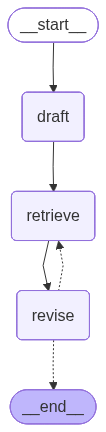

In [12]:
graph

In [14]:
result = graph.invoke({
        "messages": [HumanMessage(content="What was Amazon's balance sheet in 2023 fiscal year?")],
        "iteration_count": 0,
        "retrieved_docs": "",
        "search_queries": [],
        "is_complete": False
    })

result['messages'][-1].pretty_print()


[NODE] Draft - Generating initial answer
[DRAFT] Generated answer with 3 search queries
[REFLECTION] Missing: Exact line-item details (e.g., specific asset categories, liabilities breakdown) and the most up-to-...

[NODE] Retrieve - Fetching documents

[RETRIEVAL] Processing 3 queries
[QUERY 1] Amazon 2023 10-K balance sheet details

[TOOL] retrieve_docs called
[QUERY] Amazon 2023 10-K balance sheet details
[BM25] Ranked 20 documents by heading+content chunks
  [1] Doc 9: score=36.1705
  [2] Doc 13: score=35.0013
  [3] Doc 4: score=33.4333
  [4] Doc 8: score=32.5740
  [5] Doc 5: score=31.0747
[RETRIEVED] 3 documents
[QUERY 2] Amazon.com Inc. FY2023 total assets and liabilities

[TOOL] retrieve_docs called
[QUERY] Amazon.com Inc. FY2023 total assets and liabilities
[BM25] Ranked 7 documents by heading+content chunks
  [1] Doc 3: score=25.3410
  [2] Doc 1: score=24.4183
  [3] Doc 5: score=21.6957
  [4] Doc 4: score=20.5688
  [5] Doc 6: score=19.0774
[RETRIEVED] 3 documents
[QUERY 3] SEC

In [15]:
result = graph.invoke({
        "messages": [HumanMessage(content="Compare the Amazon's and Apple's revenue of 2024 Q1?")],
        "iteration_count": 0,
        "retrieved_docs": "",
        "search_queries": [],
        "is_complete": False
    })

result['messages'][-1].pretty_print()


[NODE] Draft - Generating initial answer
[DRAFT] Generated answer with 3 search queries
[REFLECTION] Missing: The specific revenue figures for Amazon and Apple in **2024 Q1** are missing, as they have not been ...

[NODE] Retrieve - Fetching documents

[RETRIEVAL] Processing 3 queries
[QUERY 1] Amazon Q1 2024 revenue report

[TOOL] retrieve_docs called
[QUERY] Amazon Q1 2024 revenue report
[BM25] Ranked 20 documents by heading+content chunks
  [1] Doc 3: score=28.7032
  [2] Doc 17: score=27.7033
  [3] Doc 0: score=26.7020
  [4] Doc 8: score=24.6129
  [5] Doc 10: score=24.5586
[RETRIEVED] 3 documents
[QUERY 2] Apple Q1 2024 financial results

[TOOL] retrieve_docs called
[QUERY] Apple Q1 2024 financial results
[BM25] Ranked 4 documents by heading+content chunks
  [1] Doc 1: score=22.7238
  [2] Doc 2: score=22.3212
  [3] Doc 0: score=21.5488
  [4] Doc 3: score=18.6828
[RETRIEVED] 3 documents
[QUERY 3] Latest Amazon and Apple Q1 2023 revenue comparison

[TOOL] retrieve_docs called
[QUERY]

In [16]:
result = graph.invoke({
        "messages": [HumanMessage(content="Show segment wise earning for Iphones and Macbooks in 2023")],
        "iteration_count": 0,
        "retrieved_docs": "",
        "search_queries": [],
        "is_complete": False
    })

result['messages'][-1].pretty_print()


[NODE] Draft - Generating initial answer
[DRAFT] Generated answer with 3 search queries
[REFLECTION] Missing: The exact net income attributable to iPhones and MacBooks, as Apple does not report this data. Addit...

[NODE] Retrieve - Fetching documents

[RETRIEVAL] Processing 3 queries
[QUERY 1] Apple 2023 10-K segment revenue by product

[TOOL] retrieve_docs called
[QUERY] Apple 2023 10-K segment revenue by product
[BM25] Ranked 14 documents by heading+content chunks
  [1] Doc 0: score=35.1468
  [2] Doc 5: score=32.0697
  [3] Doc 7: score=30.3880
  [4] Doc 1: score=30.3121
  [5] Doc 12: score=26.9705
[RETRIEVED] 3 documents
[QUERY 2] Apple iPhone and Mac revenue 2023

[TOOL] retrieve_docs called
[QUERY] Apple iPhone and Mac revenue 2023
[BM25] Ranked 20 documents by heading+content chunks
  [1] Doc 4: score=36.6613
  [2] Doc 2: score=30.9224
  [3] Doc 9: score=28.3123
  [4] Doc 1: score=28.1824
  [5] Doc 3: score=27.4834
[RETRIEVED] 3 documents
[QUERY 3] Apple product-specific net inc